In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import signal
from elephant.signal_processing import wavelet_transform
from elephant.spectral import welch_psd
import seaborn as sns
sns.set_theme()

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

In [2]:
output_dir = Path.home() / 'Desktop' / 'disk1' / 'ecephys_data'
cache = EcephysProjectCache.from_warehouse(manifest=output_dir / 'manifest.json')
channel_df = cache.get_channels()

In [3]:
# 1) Load session with probes in VISp and VISpm

In [4]:
session_id = 715093703
session = cache.get_session_data(session_id)

In [5]:
selected_VISpm_probe_id = 810755799 # VISpm
selected_VISp_probe_id = 810755801 # VISp

In [6]:
VISpm_lfp = session.get_lfp(selected_VISpm_probe_id)
VISp_lfp = session.get_lfp(selected_VISp_probe_id)
VISp_lfp

<xarray.DataArray 'LFP' (time: 11070604, channel: 95)>
array([[-3.7049998e-05, -4.1535000e-05, -5.5184999e-05, ...,
         2.1450001e-06, -3.1200000e-06, -1.5600000e-06],
       [ 1.6185000e-05, -2.1840000e-05, -4.1924999e-05, ...,
        -1.3650000e-06,  1.3650000e-06, -3.9000001e-06],
       [ 3.0224999e-05,  8.1899998e-06, -2.0084999e-05, ...,
         7.2150001e-06, -9.9449999e-06, -5.6549998e-06],
       ...,
       [ 3.0498000e-04,  3.2350500e-04,  2.9328000e-04, ...,
         5.8500000e-06,  2.4569999e-05, -4.0560000e-05],
       [ 2.1235499e-04,  2.6305500e-04,  2.5740001e-04, ...,
         5.0700000e-06,  2.6129999e-05, -4.1730000e-05],
       [ 1.6165500e-04,  1.8973500e-04,  1.7218500e-04, ...,
         7.7999999e-07,  8.5800002e-06, -1.6380000e-05]], dtype=float32)
Coordinates:
  * time     (time) float64 26.88 26.89 26.89 ... 9.578e+03 9.578e+03 9.578e+03
  * channel  (channel) int64 850261198 850261206 ... 850261942 850261950

In [7]:
# 2) Get the 100-300-100s times of the relevant (flash) stimulus block

In [8]:
stim_epochs = session.get_stimulus_epochs()
stim_epochs

,start_time,stop_time,duration,stimulus_name,stimulus_block
0,13.470683,73.537433,60.066750,spontaneous,null
1,73.537433,985.532551,911.995118,gabors,0.0
2,985.532551,1274.523973,288.991422,spontaneous,null
3,1274.523973,1573.023407,298.499434,flashes,1.0
4,1573.023407,1574.774823,1.751416,spontaneous,null
5,1574.774823,2174.275707,599.500885,drifting_gratings,2.0
6,2174.275707,2205.301633,31.025925,spontaneous,null
7,2205.301633,2805.836653,600.535020,natural_movie_three,3.0
8,2805.836653,2835.861733,30.025080,spontaneous,null
9,2835.861733,3136.112583,300.250850,natural_movie_one,4.0


In [9]:
flash_index = stim_epochs[stim_epochs.stimulus_name=='flashes'].index.item()

print('No stimulus block before flashes:')
print(stim_epochs[stim_epochs.index==flash_index-1])
print('\nFlashes block:')
print(stim_epochs[stim_epochs.index==flash_index])
print('\nNo stimulus block after flashes:')
print(stim_epochs[stim_epochs.index==flash_index+1])

No stimulus block before flashes:
   start_time    stop_time    duration stimulus_name stimulus_block
2  985.532551  1274.523973  288.991422   spontaneous           null

Flashes block:
    start_time    stop_time    duration stimulus_name stimulus_block
3  1274.523973  1573.023407  298.499434       flashes            1.0

No stimulus block after flashes:
    start_time    stop_time  duration stimulus_name stimulus_block
4  1573.023407  1574.774823  1.751416   spontaneous           null


In [10]:
global_start_time = stim_epochs[stim_epochs.index==flash_index-1].start_time.item()
global_end_time = stim_epochs[stim_epochs.index==flash_index+1].stop_time.item()

spontaneous_before_start_time = global_start_time
spontaneous_before_end_time = stim_epochs[stim_epochs.index==flash_index-1].stop_time.item()

flashes_start_time = stim_epochs[stim_epochs.index==flash_index].start_time.item()
flashes_end_time = stim_epochs[stim_epochs.index==flash_index].stop_time.item()

spontaneous_after_start_time = stim_epochs[stim_epochs.index==flash_index+1].start_time.item()
spontaneous_after_end_time = global_end_time

print(f'Looking at {global_start_time}s - {global_end_time}s time range')

Looking at 985.5325513570875s - 1574.7748229367066s time range


In [11]:
# 3) Select channels from VISp and VISpm only, select time range defined above only

In [12]:
# Quality check for channels that are in the LFP NWB file but not in the Allen cache
for ch in VISpm_lfp.channel.values:
    if ch not in channel_df.index.to_list():
        VISpm_lfp = VISpm_lfp.drop_sel(channel=ch)
for ch in VISp_lfp.channel.values:
    if ch not in channel_df.index.to_list():
        VISp_lfp = VISp_lfp.drop_sel(channel=ch)

In [13]:
VISpm_channel_ids = [ch for ch in VISpm_lfp.channel.values if channel_df[channel_df.index==ch]['ecephys_structure_acronym'].item()=='VISpm']
VISp_channel_ids = [ch for ch in VISp_lfp.channel.values if channel_df[channel_df.index==ch]['ecephys_structure_acronym'].item()=='VISp']

print(f'VISp channels = {len(VISp_channel_ids)}')
print(f'VISpm channels = {len(VISpm_channel_ids)}')

VISp channels = 23
VISpm channels = 16


In [14]:
# Selecting the channel in VISp and VISpm
VISpm_lfp_slice = VISpm_lfp.sel(channel=slice(VISpm_channel_ids[0], VISpm_channel_ids[-1]))
VISp_lfp_slice = VISp_lfp.sel(channel=slice(VISp_channel_ids[0], VISp_channel_ids[-1]))

In [15]:
VISpm_lfp_slice = VISpm_lfp_slice.sel(time=slice(global_start_time, global_end_time))
VISp_lfp_slice = VISp_lfp_slice.sel(time=slice(global_start_time, global_end_time))

In [16]:
# 4) Plot the LFP signal from all channels from VISp and VISpm side by side. Choose channel with maximum signal

In [17]:
def get_max_channel_id(data):
    max_amplitudes = np.max(np.abs(data), axis=0)
    return int(np.argmax(max_amplitudes.data))

def get_max_channel_id_list(data):
    max_amplitudes = np.max(np.abs(data), axis=0)
    return np.argsort(-max_amplitudes).data

In [18]:
VISpm_max_channel = VISpm_channel_ids[get_max_channel_id(VISpm_lfp_slice)]
VISp_max_channel = VISp_channel_ids[get_max_channel_id(VISp_lfp_slice)]
print(f'VISpm_max_channel = {VISpm_max_channel}')
print(f'VISp_max_channel = {VISp_max_channel}')

VISpm_max_channel_list = get_max_channel_id_list(VISpm_lfp_slice)
VISp_max_channel_list = get_max_channel_id_list(VISp_lfp_slice)

VISpm_max_channel = 850263332
VISp_max_channel = 850261814


In [19]:
VISp_channel_ids[VISp_max_channel_list[0]]

850261814

In [20]:
VISpm_lfp_slice

<xarray.DataArray 'LFP' (time: 736551, channel: 16)>
array([[-5.49899996e-05, -2.18400000e-05, -2.61299992e-05, ...,
         1.75499990e-05,  1.75499997e-06, -2.51549991e-05],
       [-3.50999981e-05, -1.13099995e-05, -2.73000001e-06, ...,
         2.08649999e-05, -2.82750007e-05, -2.41799989e-05],
       [-3.31500014e-05,  9.75000034e-07,  8.58000021e-06, ...,
         7.80000028e-06, -2.86649993e-05, -1.83299999e-05],
       ...,
       [-1.13294998e-04, -1.25385006e-04, -1.11734997e-04, ...,
        -1.08809996e-04, -8.22899965e-05, -5.71349992e-05],
       [-9.53549970e-05, -1.12905000e-04, -1.17390002e-04, ...,
        -9.86699961e-05, -7.31249966e-05, -6.53250027e-05],
       [-9.30149981e-05, -1.06859996e-04, -9.94500006e-05, ...,
        -7.58550013e-05, -6.16199977e-05, -6.00599997e-05]], dtype=float32)
Coordinates:
  * time     (time) float64 985.5 985.5 985.5 ... 1.575e+03 1.575e+03 1.575e+03
  * channel  (channel) int64 850263268 850263276 ... 850263380 850263388

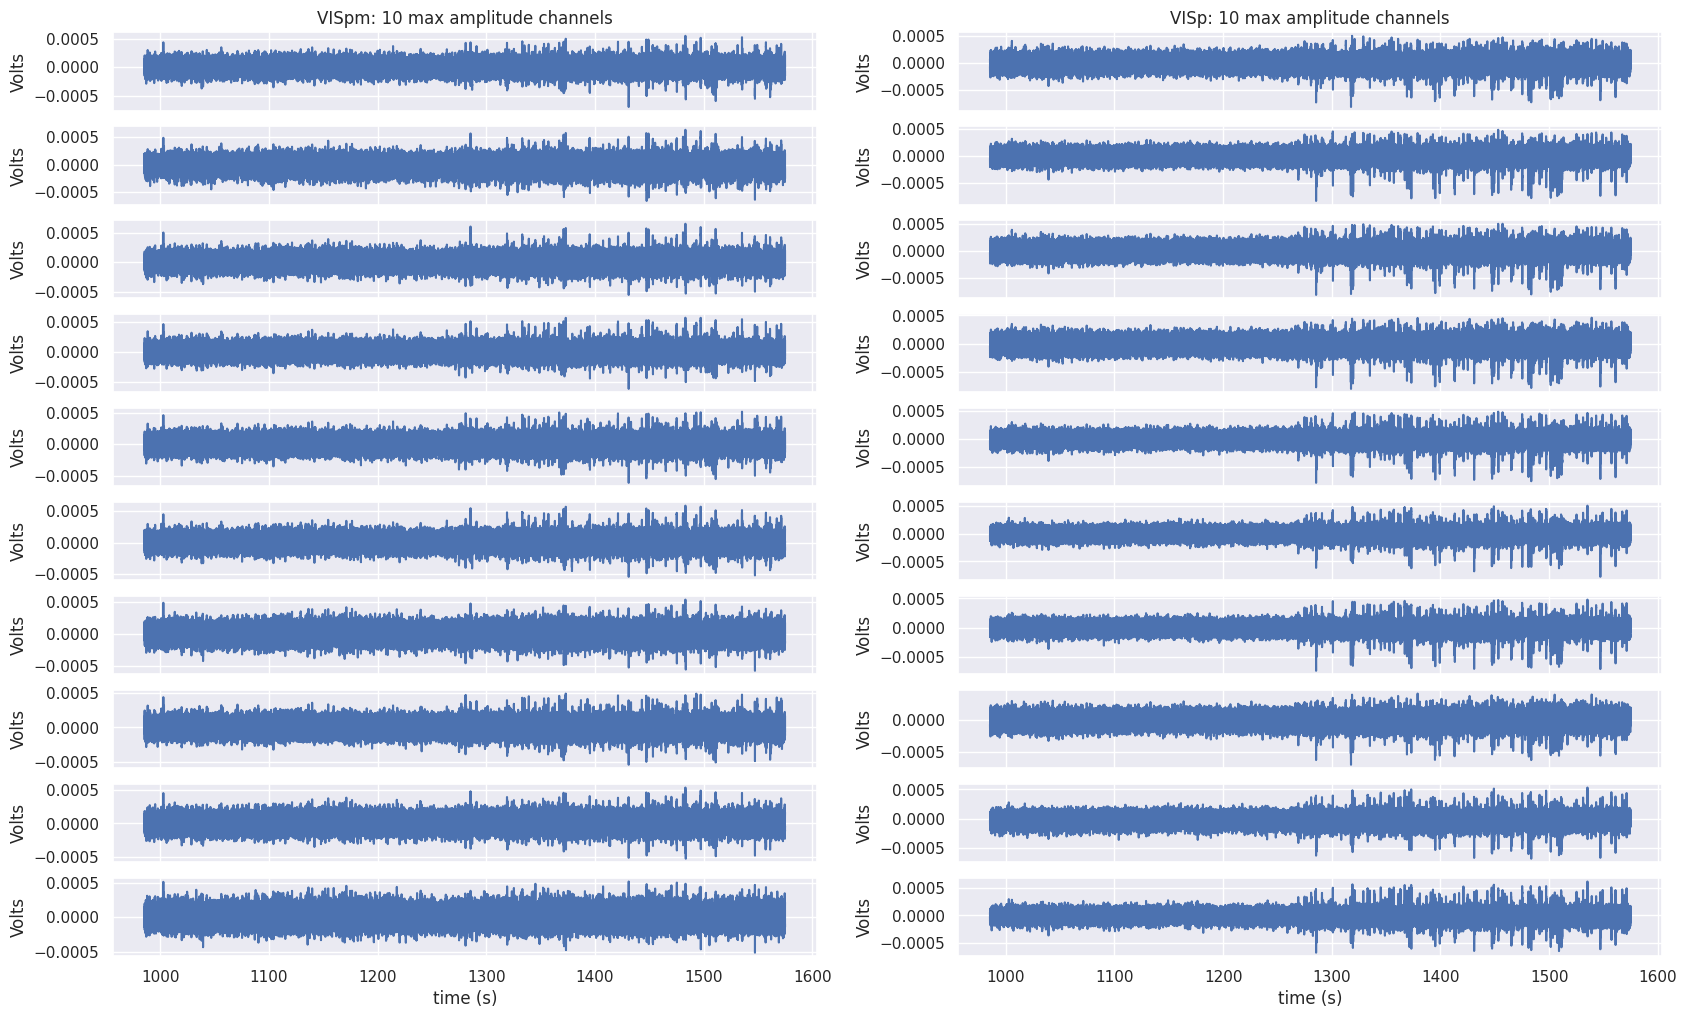

In [21]:
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(20, 12), sharex=True)
for i in range(10):
    axes[i][0].plot(VISpm_lfp_slice.time, VISpm_lfp_slice.sel(channel=VISpm_channel_ids[VISpm_max_channel_list[i]]))
    axes[i][0].set_ylabel(f'Volts')
axes[i][0].set_xlabel('time (s)')
axes[0][0].set_title('VISpm: 10 max amplitude channels')

for i in range(10):
    axes[i][1].plot(VISp_lfp_slice.time, VISp_lfp_slice.sel(channel=VISp_channel_ids[VISp_max_channel_list[i]]))
    axes[i][1].set_ylabel(f'Volts')
axes[i][1].set_xlabel('time (s)')
axes[0][1].set_title('VISp: 10 max amplitude channels')


plt.show()

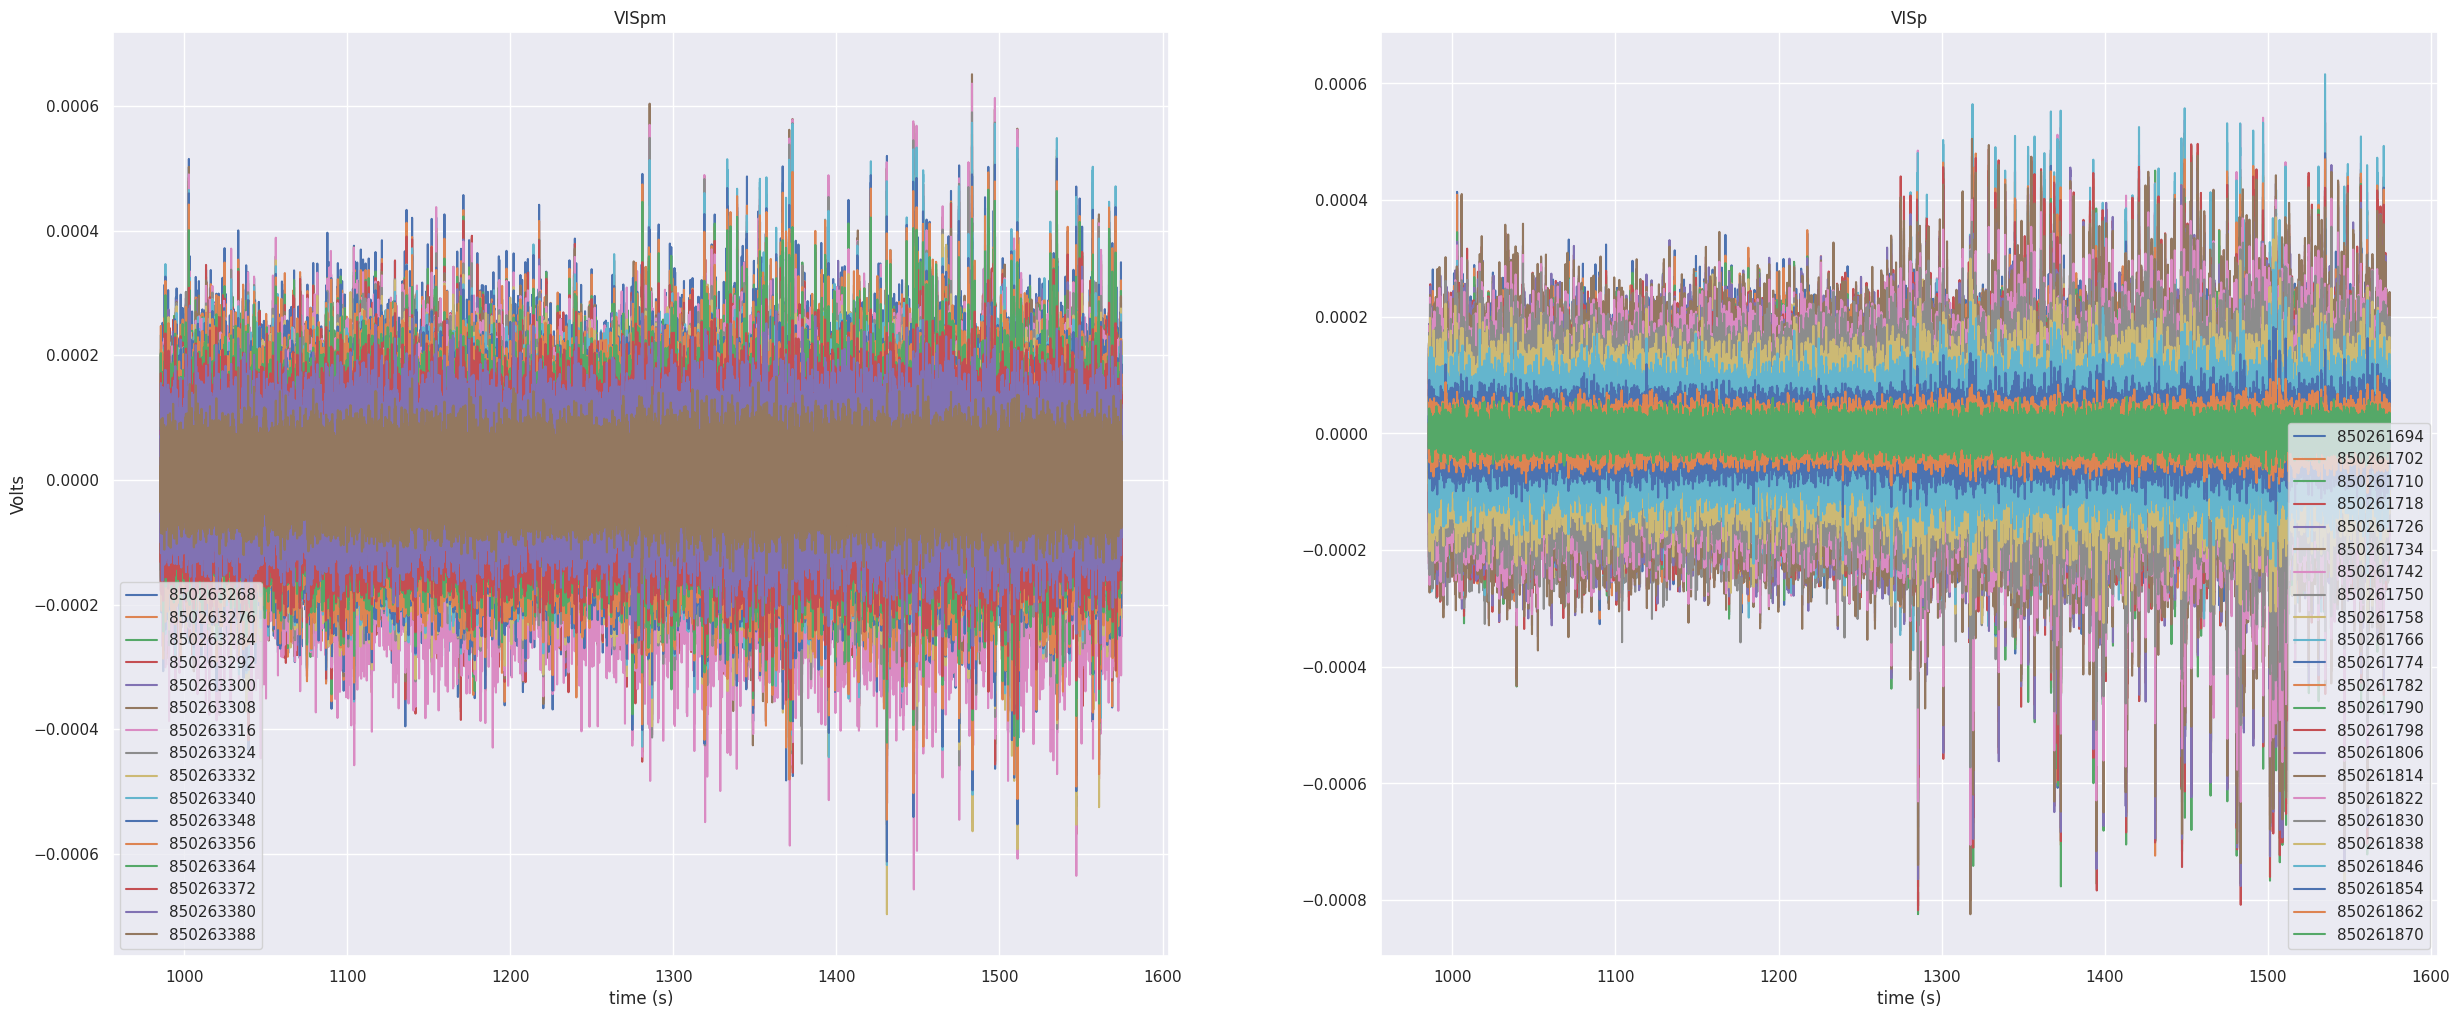

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 12), sharex=True)
for i in range(len(VISpm_channel_ids)):
    axes[0].plot(VISpm_lfp_slice.time, VISpm_lfp_slice.sel(channel=VISpm_channel_ids[i]))
axes[0].set_ylabel(f'Volts')
axes[0].set_xlabel('time (s)')
axes[0].legend(VISpm_channel_ids)
axes[0].set_title('VISpm')

for i in range(len(VISp_channel_ids)):
    axes[1].plot(VISp_lfp_slice.time, VISp_lfp_slice.sel(channel=VISp_channel_ids[i]))
axes[1].set_xlabel('time (s)')
axes[1].legend(VISp_channel_ids)
axes[1].set_title('VISp')

plt.show()

In [23]:
# 5) Compute spectrogram from that channel

In [24]:
fs = 1250
freq_list = np.arange(1,10,9/50)
print(freq_list)

VISpm_wt_data = wavelet_transform(VISpm_lfp_slice.sel(channel=VISpm_max_channel), frequency=freq_list, sampling_frequency=fs)
VISp_wt_data = wavelet_transform(VISp_lfp_slice.sel(channel=VISp_max_channel), frequency=freq_list, sampling_frequency=fs)

[1.   1.18 1.36 1.54 1.72 1.9  2.08 2.26 2.44 2.62 2.8  2.98 3.16 3.34
 3.52 3.7  3.88 4.06 4.24 4.42 4.6  4.78 4.96 5.14 5.32 5.5  5.68 5.86
 6.04 6.22 6.4  6.58 6.76 6.94 7.12 7.3  7.48 7.66 7.84 8.02 8.2  8.38
 8.56 8.74 8.92 9.1  9.28 9.46 9.64 9.82]


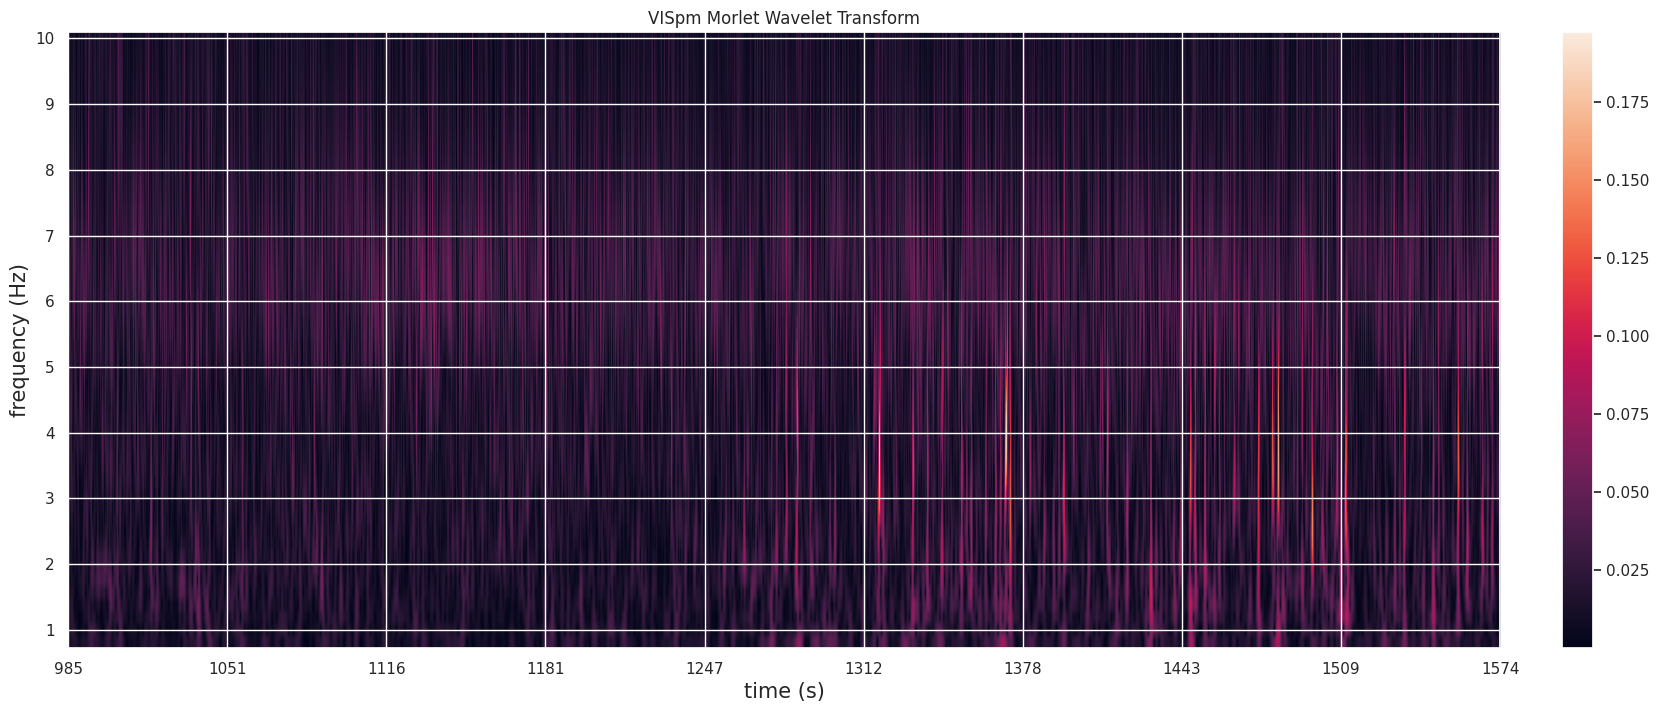

In [25]:
fig,ax = plt.subplots(figsize=(20,8))
im = ax.imshow(np.abs(VISpm_wt_data)[:,:],aspect='auto',origin='lower')

x_ticks_list = VISpm_lfp_slice.time.data

ax.set_xticks(np.linspace(0,VISpm_wt_data.shape[1],num=10))
ax.set_xticklabels(np.linspace(x_ticks_list[0],x_ticks_list[-1], num=10).astype(int))
ax.set_yticks(np.linspace(1,len(freq_list)-1,num=10))
ax.set_yticklabels(np.arange(1,11))

ax.set_xlabel("time (s)", fontsize=15)
ax.set_ylabel("frequency (Hz)", fontsize=15)

ax.set_title('VISpm Morlet Wavelet Transform')

fig.colorbar(im, fraction=0.036, pad=0.04)
# plt.xlim([1300,1306])

plt.show()

In [26]:
# 6) Compute binned PSD from that channel for the three (100-300-100) segments

Text(0, 0.5, 'power (V**2/Hz)')

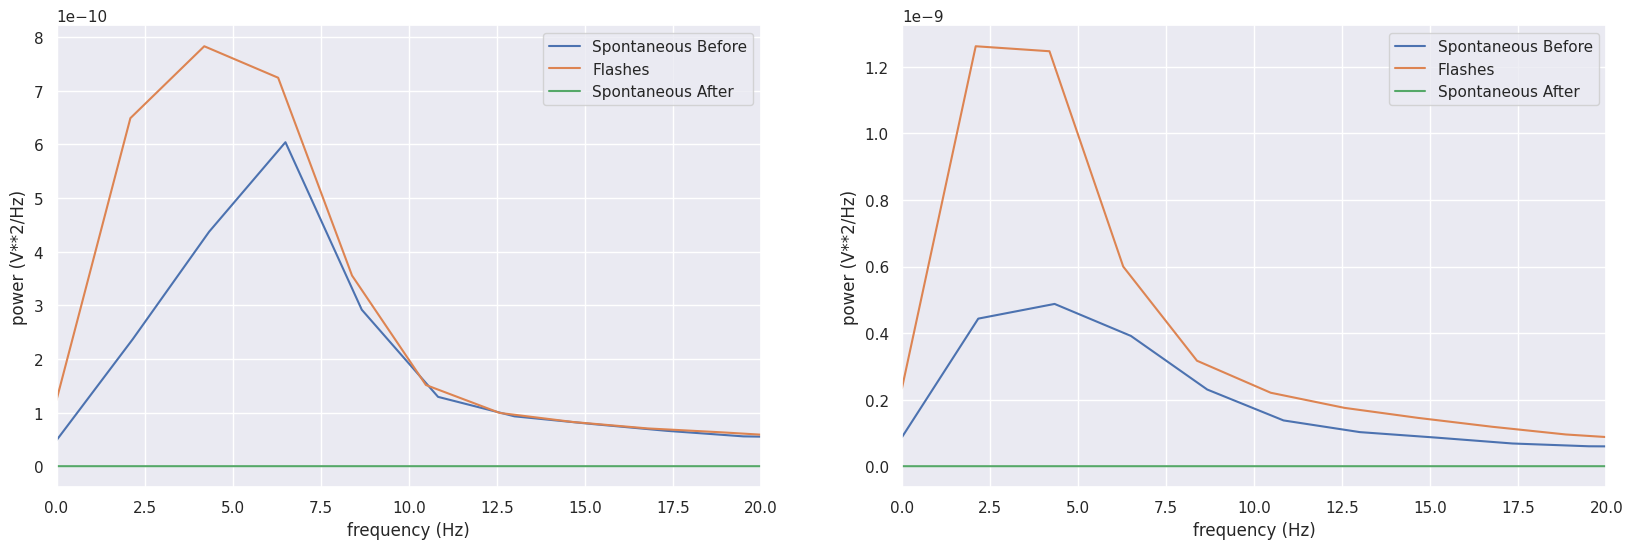

In [27]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(20,6))

f1, psd1 = welch_psd(VISpm_lfp_slice.sel(channel=VISpm_max_channel).sel(time=slice(spontaneous_before_start_time, spontaneous_before_end_time)).data, fs=1250, overlap=0, n_segments=fs/2)
f2, psd2 = welch_psd(VISpm_lfp_slice.sel(channel=VISpm_max_channel).sel(time=slice(flashes_start_time, flashes_end_time)).data, fs=1250, overlap=0, n_segments=fs/2)
f3, psd3 = welch_psd(VISpm_lfp_slice.sel(channel=VISpm_max_channel).sel(time=slice(spontaneous_after_start_time, spontaneous_after_end_time)).data, fs=1250, overlap=0, n_segments=fs/2)

# plt.semilogy(f, psd)

ax1.plot(f1,psd1)
ax1.plot(f2,psd2)
ax1.plot(f3,psd3)
ax1.legend(['Spontaneous Before','Flashes','Spontaneous After'])
ax1.set_xlim([0,20])
ax1.set_xlabel('frequency (Hz)')
ax1.set_ylabel('power (V**2/Hz)')

f1, psd1 = welch_psd(VISp_lfp_slice.sel(channel=VISp_max_channel).sel(time=slice(spontaneous_before_start_time, spontaneous_before_end_time)).data, fs=1250, overlap=0, n_segments=fs/2)
f2, psd2 = welch_psd(VISp_lfp_slice.sel(channel=VISp_max_channel).sel(time=slice(flashes_start_time, flashes_end_time)).data, fs=1250, overlap=0, n_segments=fs/2)
f3, psd3 = welch_psd(VISp_lfp_slice.sel(channel=VISp_max_channel).sel(time=slice(spontaneous_after_start_time, spontaneous_after_end_time)).data, fs=1250, overlap=0, n_segments=fs/2)

# plt.semilogy(f, psd)

ax2.plot(f1,psd1)
ax2.plot(f2,psd2)
ax2.plot(f3,psd3)
ax2.legend(['Spontaneous Before','Flashes','Spontaneous After'])
ax2.set_xlim([0,20])
ax2.set_xlabel('frequency (Hz)')
ax2.set_ylabel('power (V**2/Hz)')

# plt.gca().set_xscale('log')
# plt.gca().set_yscale('log')

In [28]:
f1

array([  0.        ,   2.16637782,   4.33275563,   6.49913345,
         8.66551127,  10.83188908,  12.9982669 ,  15.16464471,
        17.33102253,  19.49740035,  21.66377816,  23.83015598,
        25.9965338 ,  28.16291161,  30.32928943,  32.49566724,
        34.66204506,  36.82842288,  38.99480069,  41.16117851,
        43.32755633,  45.49393414,  47.66031196,  49.82668977,
        51.99306759,  54.15944541,  56.32582322,  58.49220104,
        60.65857886,  62.82495667,  64.99133449,  67.15771231,
        69.32409012,  71.49046794,  73.65684575,  75.82322357,
        77.98960139,  80.1559792 ,  82.32235702,  84.48873484,
        86.65511265,  88.82149047,  90.98786828,  93.1542461 ,
        95.32062392,  97.48700173,  99.65337955, 101.81975737,
       103.98613518, 106.152513  , 108.31889081, 110.48526863,
       112.65164645, 114.81802426, 116.98440208, 119.1507799 ,
       121.31715771, 123.48353553, 125.64991334, 127.81629116,
       129.98266898, 132.14904679, 134.31542461, 136.48

In [29]:
# 7) For other areas recorded in VISp and VISpm probes, repeat Step 5.